### Preamble

In [10]:
import sympy as sym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
from FwtModels import effective_aoa as eAoA

# Simplify the $\alpha_h$ Model

Previously I have generated a geometrically exact representation of the effective AoA of the hinged wingtip, the aim of this document is to turn this into a simplified model which can be more readily used in simulations

# Generate the geometrically exact model and produce numerical data for it

In [11]:
## a/c to wind transform
alpha,beta = sym.symbols(['alpha','beta'])
Lambda,theta = sym.symbols(['Lambda','theta'])

# Velocity vector in velocity frame is of the form [v 0 0]
u = sym.Symbol('u')
V = sym.Matrix([u,0,0])


Vh = eAoA.GeomExact(alpha,beta,Lambda,theta,V)

ExactModel = sym.lambdify((alpha,beta,Lambda,theta,u),Vh)
Vh
Vh.subs({theta:0,beta:0})

Matrix([
[u*cos(alpha)],
[           0],
[u*sin(alpha)]])

In [12]:
aoa_r =0
aoa =[]
for i in range(-5,6):
    a = np.deg2rad([aoa_r,0,-25,i])
    v = ExactModel(*a,1).T[0]
    aoa.append(np.arctan(v[2]/v[0]))
    
np.array(aoa)-aoa_r/180*np.pi

array([ 0.03684198,  0.02948464,  0.02211994,  0.0147497 ,  0.00737577,
        0.        , -0.00737577, -0.0147497 , -0.02211994, -0.02948464,
       -0.03684198])

In [13]:
# Create test conditions
AoAs = np.linspace(0,10,5)
Thetas = np.linspace(-180,180,361)
Lambdas = np.linspace(-25,0,6)
Betas = np.array([0])

dat = []

for i in AoAs:
    aoa_r = np.deg2rad(i)
    for j in Thetas:
        theta_r = np.deg2rad(j)
        for k in Lambdas:
            Lambda_r = np.deg2rad(k)
            for w in Betas:
                beta_r = np.deg2rad(w)
                dat.append([i,j,k,w])

TestConditions = pd.DataFrame(data = dat,columns=['Alpha','Theta','Lambda','Beta'])

In [14]:
V=Vh.subs({beta:0,sym.sin(alpha):alpha,sym.cos(alpha):1}).subs({alpha:0})
sweep = V[2]/V[0]
alpha_h = sym.Symbol('alpha_h')

eq = sym.Eq(sym.tan(alpha_h),sweep.simplify())
sym.print_latex(eq)

\tan{\left(\alpha_{h} \right)} = \frac{\sin{\left(\Lambda \right)} \sin{\left(\theta \right)}}{\sin^{2}{\left(\Lambda \right)} \cos{\left(\theta \right)} - \sin^{2}{\left(\Lambda \right)} + 1}


In [15]:
# function to convert a function for v relationship into AoA info
def GetFwtAoAFromModel(TestConditions,func,ModelName,includeZeroLift=False):
    ModelData = TestConditions.copy()
    # get list of velocoty vectors
    alpha = np.deg2rad(ModelData['Alpha'])
    beta = np.deg2rad(ModelData['Beta'])
    Lambda = np.deg2rad(ModelData['Lambda'])
    theta = np.deg2rad(ModelData['Theta'])
    l_vs = func(alpha,beta,Lambda,theta,1).T
    #convert vectors to 2D array
    vs = []
    for i in l_vs:
        vs.append(i[0])
    vs = np.array(vs)
    # add velocity components to df
    ModelData = pd.concat([ModelData,pd.DataFrame(data=vs,columns=['v1','v2','v3'])],axis=1)
    # Add other info
    ModelData['Alpha_h'] = np.rad2deg((ModelData['v3']/ModelData['v1']).apply(np.arctan))
    ModelData['DeltaAlpha_h'] = ModelData['Alpha_h']-ModelData['Alpha']
    ModelData['Beta_h'] = np.rad2deg((ModelData['v2']/ModelData['v1']).apply(np.arctan))
    ModelData['DeltaBeta_h'] = ModelData['Beta_h']-ModelData['Beta']
    ModelData['u_h'] = np.sqrt(ModelData['v3']**2 + ModelData['v1']**2)
    ModelData['Lift'] = ModelData['u_h']**2*np.deg2rad(ModelData['Alpha_h'])*np.cos(np.deg2rad(ModelData['Alpha_h']))
    
    ModelData['ZeroLift'] = alpha*np.cos(np.deg2rad(ModelData['Alpha']))
    if includeZeroLift:
        ModelData['Lift'] = ModelData['Lift'] + ModelData['ZeroLift']
    
    ModelData['DeltaLift'] = ModelData['Lift']-ModelData['ZeroLift']
    ModelData['Model'] = ModelName
    return ModelData

In [16]:
#convert exact model
ModelData = GetFwtAoAFromModel(TestConditions,ExactModel,'Exact')

In [17]:
# plot the interesting things
#fig, axes = plt.subplots(1,2,figsize=(15,5))
#dat = ModelData[ModelData['Lambda']==-5]
#sns.lineplot(data = dat,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0])
#axes[0].set(title='Variation in Delta Alpha for Lambda = -5')


#ModelData['Lift'] = ModelData['u_h']**2*np.deg2rad(ModelData['Alpha_h'])*np.cos(np.deg2rad(ModelData['Alpha_h']))
#dat = ModelData[ModelData['Lambda']==-10]

#sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[1])
#axes[1].set(title='Variation in Delta Alpha for Lambda = -10')

In [18]:
M = ModelData
M = M[(M['Theta']==1) & (M['Lambda']==-25)].copy()
M['test'] = M['Alpha']*np.cos(np.deg2rad(M['Alpha']))
M['test2'] = M['Alpha_h']*np.cos(np.deg2rad(M['Alpha_h']))
M

,Alpha,Theta,Lambda,Beta,v1,v2,v3,Alpha_h,DeltaAlpha_h,Beta_h,DeltaBeta_h,u_h,Lift,ZeroLift,DeltaLift,Model,test,test2
1086,0.0,1.0,-25.0,0,0.999973,-0.000058,-0.007376,-0.422601,-0.422601,-0.003343,-0.003343,1.000000,-0.007376,0.000000,-0.007376,Exact,0.000000,-0.422589
3252,2.5,1.0,-25.0,0,0.999343,0.000632,0.036244,2.077087,-0.422913,0.036215,0.036215,1.000000,0.036228,0.043592,-0.007364,Exact,2.497621,2.075722
5418,5.0,1.0,-25.0,0,0.996810,0.001320,0.079795,4.576777,-0.423223,0.075898,0.075898,0.999999,0.079625,0.086934,-0.007309,Exact,4.980973,4.562183
7584,7.5,1.0,-25.0,0,0.992381,0.002007,0.123194,7.076471,-0.423529,0.115860,0.115860,0.999998,0.122566,0.129780,-0.007213,Exact,7.435836,7.022567
9750,10.0,1.0,-25.0,0,0.986062,0.002689,0.166358,9.576172,-0.423828,0.156257,0.156257,0.999996,0.164806,0.171881,-0.007076,Exact,9.848078,9.442731


In [19]:
M = LinModelData
M = M[(M['Theta']==1) & (M['Lambda']==-25)]
M

NameError: name 'LinModelData' is not defined

The above two plots capture all of the nono-linear geometric effects of the FWT, the aim is to now create a model that closely these plots with simplier equations the the ones below:

## Compare to the current model

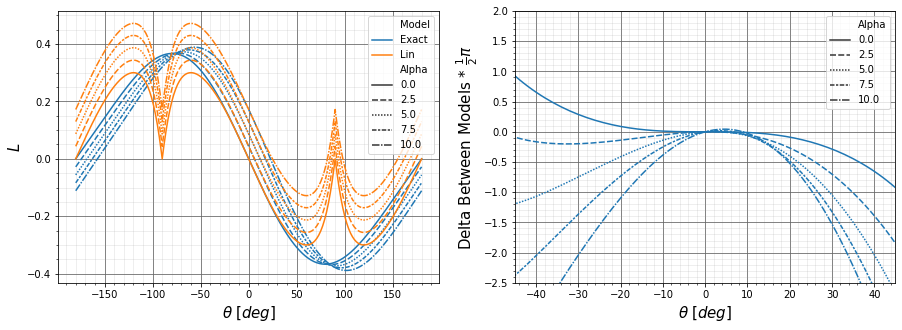

In [20]:
linAlpha = sym.atan(sym.tan(theta)*sym.sin(Lambda))*sym.cos(theta)
V = sym.ones(3,1)
V[0] = sym.cos(linAlpha)*u
V[1] = sym.cos(linAlpha)*1e-10 # just a cheat to ensure an array is returned
V[2] = sym.sin(linAlpha)*u
linModel = sym.lambdify((alpha,beta,Lambda,theta,u),V)

LinModelData = GetFwtAoAFromModel(TestConditions,linModel,'Lin',includeZeroLift=True)
#LinModelData['DeltaAlpha_h'] = LinModelData['Alpha_h']
#LinModelData['DeltaLift'] = LinModelData['DeltaLift'] + np.deg2rad(LinModelData['Alpha'])*np.cos(np.deg2rad(LinModelData['Alpha']))
Data = ModelData.append(LinModelData,sort=False)
DeltaData = ModelData.copy()
DeltaData['DeltaAlpha_h'] = (DeltaData['DeltaAlpha_h'] - LinModelData['DeltaAlpha_h'])
DeltaData['DeltaLift'] = (DeltaData['Lift'] - LinModelData['Lift'])/np.pi*180
#DeltaData['DeltaLift'] = (DeltaData['Theta']!=0)*DeltaData['DeltaLift']
#remove 




Lam = -25
# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(1,2,figsize=(15,5))
dat = Data[Data['Lambda']==Lam]
sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[0],hue='Model')
#axes[0][0].set(ylim=(-10,10),xlim=(-50,50))
sns.lineplot(data = DeltaData[DeltaData['Lambda']==Lam],x='Theta',y='DeltaLift',style='Alpha',ax=axes[1])

axes[0].set_ylabel(r'$L$',fontsize=15)
axes[1].set_ylabel(r'Delta Between Models * $\frac{1}{2}\pi$',fontsize=15)
#axes[0].set(xlim=(-30,30),ylim=(-10,10))
axes[1].set(xlim=(-45,45),ylim=(-2.5,2))

for i in [0,1]:
    axes[i].grid(b=True, which='major', color='#666666', linestyle='-')
    axes[i].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
    #Show the minor grid lines with very faint and almost transparent grey lines
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
imageFolder = r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop' '\\'
plt.savefig(imageFolder +  r'LinModelCompare.png',transparent=True,bbox_inches='tight')

Large differences between the models, even at lowish Theta (<20 degrees)

## convert Linear into follower

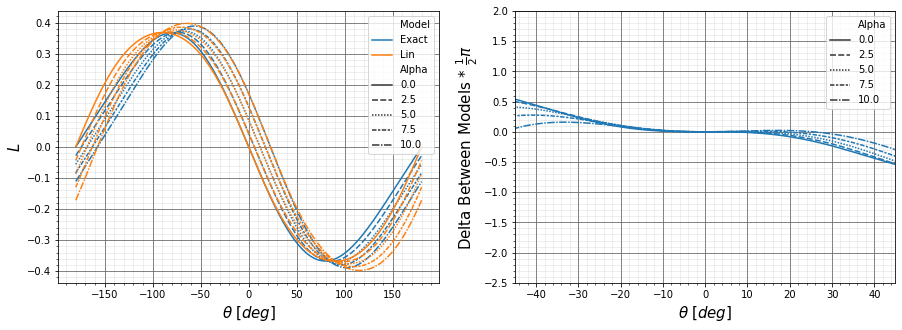

In [21]:
linAlpha = sym.atan(sym.sin(theta)*sym.sin(Lambda))+alpha*sym.cos(theta)
V = sym.ones(3,1)
V[0] = sym.cos(linAlpha)*u
V[1] = sym.cos(linAlpha)*1e-10 # just a cheat to ensure an array is returned
V[2] = sym.sin(linAlpha)*u
linModel = sym.lambdify((alpha,beta,Lambda,theta,u),V)

LinModelData = GetFwtAoAFromModel(TestConditions,linModel,'Lin',includeZeroLift=False)
#LinModelData['DeltaAlpha_h'] = LinModelData['Alpha_h']
#LinModelData['DeltaLift'] = LinModelData['DeltaLift'] + np.deg2rad(LinModelData['Alpha'])*np.cos(np.deg2rad(LinModelData['Alpha']))
Data = ModelData.append(LinModelData,sort=False)
DeltaData = ModelData.copy()
DeltaData['DeltaAlpha_h'] = (DeltaData['DeltaAlpha_h'] - LinModelData['DeltaAlpha_h'])
DeltaData['DeltaLift'] = (DeltaData['Lift'] - LinModelData['Lift'])/np.pi*180
#DeltaData['DeltaLift'] = (DeltaData['Theta']!=0)*DeltaData['DeltaLift']
#remove 




Lam = -25
# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(1,2,figsize=(15,5))
dat = Data[Data['Lambda']==Lam]
sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[0],hue='Model')
#axes[0][0].set(ylim=(-10,10),xlim=(-50,50))
sns.lineplot(data = DeltaData[DeltaData['Lambda']==Lam],x='Theta',y='DeltaLift',style='Alpha',ax=axes[1])

axes[0].set_ylabel(r'$L$',fontsize=15)
axes[1].set_ylabel(r'Delta Between Models * $\frac{1}{2}\pi$',fontsize=15)
#axes[0].set(xlim=(-30,30),ylim=(-10,10))
axes[1].set(xlim=(-45,45),ylim=(-2.5,2))

for i in [0,1]:
    axes[i].grid(b=True, which='major', color='#666666', linestyle='-')
    axes[i].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
    #Show the minor grid lines with very faint and almost transparent grey lines
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
imageFolder = r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop' '\\'
plt.savefig(imageFolder +  r'LinFollowerModelCompare.png',transparent=True,bbox_inches='tight')

## 'Compare to Non-linear Aeroelastic Behaviuor of Hinged wing-tips'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AE1F89A88>,
      dtype=object)

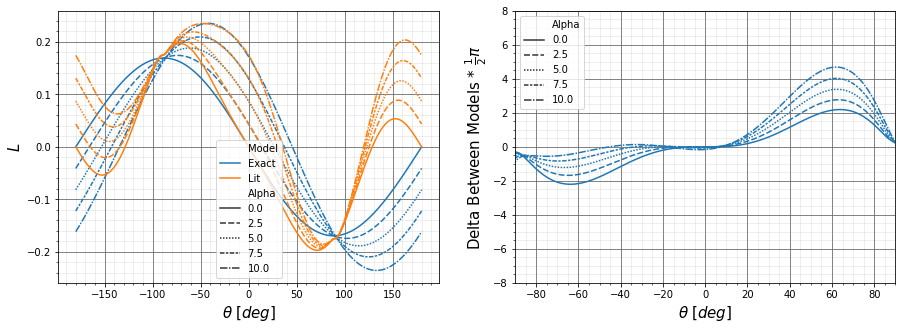

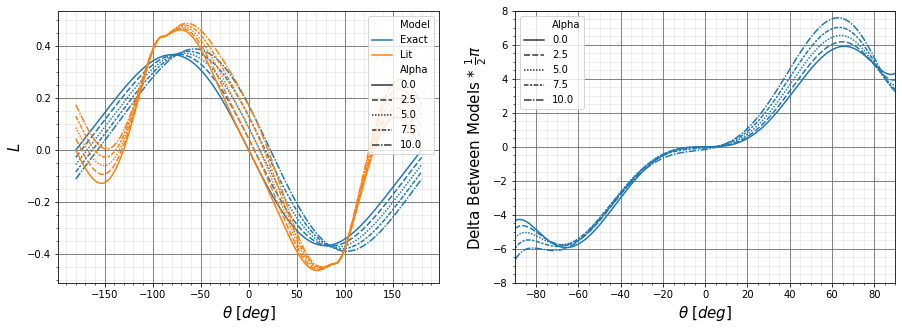

In [22]:
# create forces
LitModelData = TestConditions.copy()

alp = np.deg2rad(LitModelData['Alpha'])
thet = np.deg2rad(LitModelData['Theta'])
lam = np.deg2rad(LitModelData['Lambda'])
LitModelData['Lift'] = alp*np.cos(thet)**2 # lift due to root AoA
LitModelData['Lift'] = LitModelData['Lift'] + np.arctan(np.sin(lam)*np.tan(thet))*np.cos(thet)**2 # lift due to flare-twist coupling
LitModelData['Lift'] = LitModelData['Lift'] + lam * np.sin(thet)**3 # side force contibution
LitModelData['Model'] = 'Lit'
Data = ModelData.append(LitModelData,sort=False)
DeltaData = ModelData.copy()
DeltaData['DeltaLift'] = (DeltaData['Lift'] - LitModelData['Lift'])/np.pi*180

def MakePlot(Lam,ModelStr,xlim=(-90,90)):
    # compare to the exact
    # plot the interesting things
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    dat = Data[Data['Lambda']==Lam]
    sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[0],hue='Model')
    #axes[0][0].set(ylim=(-10,10),xlim=(-50,50))
    sns.lineplot(data = DeltaData[DeltaData['Lambda']==Lam],x='Theta',y='DeltaLift',style='Alpha',ax=axes[1])

    axes[0].set_ylabel(r'$L$',fontsize=15)
    axes[1].set_ylabel(r'Delta Between Models * $\frac{1}{2}\pi$',fontsize=15)
    #axes[0].set(xlim=(-30,30),ylim=(-10,10))
    axes[1].set(xlim=xlim,ylim=(-8,8))

    for i in [0,1]:
        axes[i].grid(b=True, which='major', color='#666666', linestyle='-')
        axes[i].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
        #Show the minor grid lines with very faint and almost transparent grey lines
        axes[i].minorticks_on()
        axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    imageFolder = r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop' '\\'
    plt.savefig(imageFolder +  f'{ModelStr}ModelCompare_lambda{Lam:.0f}.png',transparent=True,bbox_inches='tight')
    return axes

MakePlot(-10,'Lit')
MakePlot(-25,'Lit')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AE4921F08>,
      dtype=object)

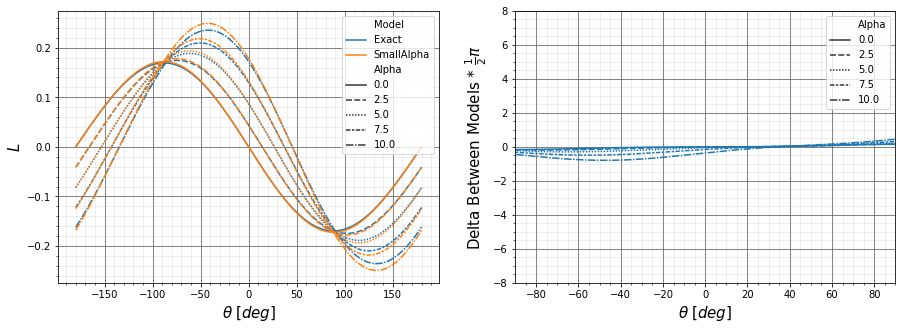

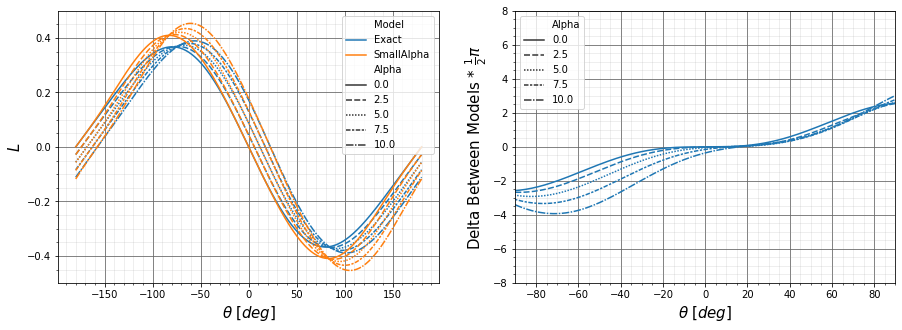

In [31]:
# create forces
LitModelData = TestConditions.copy()

alp = np.deg2rad(LitModelData['Alpha'])
thet = np.deg2rad(LitModelData['Theta'])
lam = np.deg2rad(LitModelData['Lambda'])

LitModelData['v0'] = -alp*np.sin(lam)*np.sin(thet)+np.sin(lam)**2*np.cos(thet)-np.sin(lam)**2+1
LitModelData['v1'] = (alp*np.sin(thet)-np.sin(lam)*np.cos(thet)+np.sin(lam))*np.cos(lam)
LitModelData['v2'] = alp*np.cos(thet)+np.sin(lam)*np.sin(thet)

LitModelData['Lift'] = np.arctan(LitModelData['v2']/LitModelData['v0'])*(LitModelData['v2']**2+LitModelData['v0']**2) # lift due to flare-twist coupling
#LitModelData['Lift'] = LitModelData['Lift'] + lam * np.sin(thet)**3 # side force contibution
LitModelData['Model'] = 'SmallAlpha'



Data = ModelData.append(LitModelData,sort=False)
DeltaData = ModelData.copy()
DeltaData['DeltaLift'] = (DeltaData['Lift'] - LitModelData['Lift'])/np.pi*180

def MakePlot(Lam,ModelStr,xlim=(-90,90)):
    # compare to the exact
    # plot the interesting things
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    dat = Data[Data['Lambda']==Lam]
    sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[0],hue='Model')
    #axes[0][0].set(ylim=(-10,10),xlim=(-50,50))
    sns.lineplot(data = DeltaData[DeltaData['Lambda']==Lam],x='Theta',y='DeltaLift',style='Alpha',ax=axes[1])

    axes[0].set_ylabel(r'$L$',fontsize=15)
    axes[1].set_ylabel(r'Delta Between Models * $\frac{1}{2}\pi$',fontsize=15)
    #axes[0].set(xlim=(-30,30),ylim=(-10,10))
    axes[1].set(xlim=xlim,ylim=(-8,8))

    for i in [0,1]:
        axes[i].grid(b=True, which='major', color='#666666', linestyle='-')
        axes[i].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
        #Show the minor grid lines with very faint and almost transparent grey lines
        axes[i].minorticks_on()
        axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    imageFolder = r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop' '\\'
    plt.savefig(imageFolder +  f'{ModelStr}ModelCompare_lambda{Lam:.0f}.png',transparent=True,bbox_inches='tight')
    return axes

MakePlot(-10,'SmallAlpha')
MakePlot(-25,'SmallAlpha')

## can I do Better?

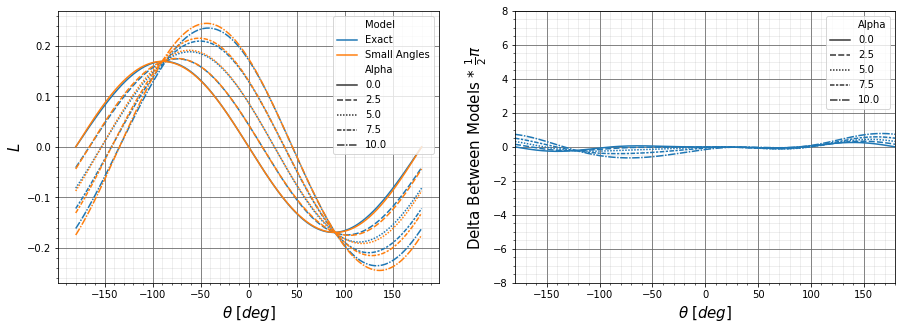

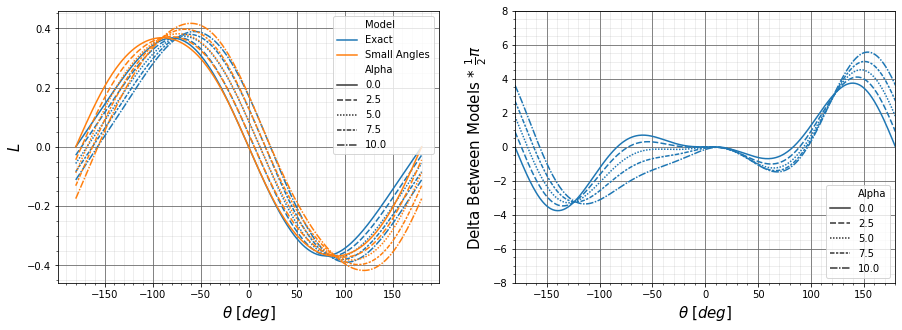

In [446]:
# create forces
LitModelData = TestConditions.copy()

alp = np.deg2rad(LitModelData['Alpha'])
thet = np.deg2rad(LitModelData['Theta'])
lam = np.deg2rad(LitModelData['Lambda'])
sweep = lam*(np.cos(thet)-1)
effectiveV = np.cos(sweep)
LitModelData['Lift'] = alp*np.cos(thet) # lift due to root AoA


aoa_h = np.arctan(np.sin(lam)*np.sin(thet))#/(np.sin(lam)**2*np.cos(thet)-np.sin(lam)**2+1))
LitModelData['Lift'] = LitModelData['Lift'] + aoa_h*np.cos(aoa_h) # lift due to flare-twist coupling

LitModelData['Model'] = 'Small Angles'
Data = ModelData.append(LitModelData,sort=False)
DeltaData = ModelData.copy()
DeltaData['DeltaLift'] = (DeltaData['Lift'] - LitModelData['Lift'])/np.pi*180

axes = MakePlot(-10,'Small_Angles',xlim=(-180,180))
axes = MakePlot(-25,'Small_Angles',xlim=(-180,180))


## Linearise the exact equation w.r.t. $\alpha$

As AoA of r will rarely +/- 10 can linearise this part of the equation

also for now we are ignoring Beta

In [444]:
Vh_lin = Vh.subs({sym.sin(alpha):alpha,sym.cos(alpha):1,beta:0})

#Looking at alpha_h
sym.Eq(sym.tan(alpha_h),Vh_lin[2]/Vh_lin[0])
VLinModel = sym.lambdify((alpha,beta,Lambda,theta,u),Vh_lin)

Matrix([
[             u*(-alpha*sin(Lambda)*sin(theta) + sin(Lambda)**2*cos(theta) - sin(Lambda)**2 + 1)],
[u*(alpha*sin(theta)*cos(Lambda) - sin(Lambda)*cos(Lambda)*cos(theta) + sin(Lambda)*cos(Lambda))],
[                                                  u*(alpha*cos(theta) + sin(Lambda)*sin(theta))]])

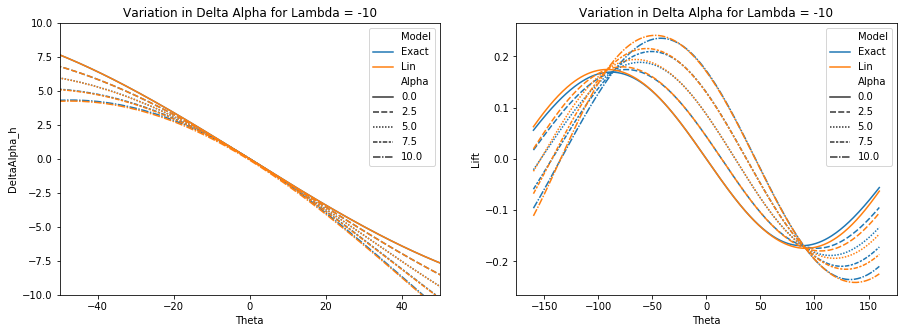

In [27]:
LinModelData = GetFwtAoAFromModel(TestConditions,VLinModel,'Lin')
LinModelData['Lift'] = np.deg2rad(LinModelData['Alpha_h'])*np.cos(np.deg2rad(ModelData['Alpha_h']))
Data = ModelData.append(LinModelData,sort=False)


# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(1,2,figsize=(15,5))
dat = Data[Data['Lambda']==-10]
sns.lineplot(data = dat,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0],hue='Model')
axes[0].set(title='Variation in Delta Alpha for Lambda = -10')
axes[0].set(ylim=(-10,10),xlim=(-50,50))

sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[1],hue='Model')
axes[1].set(title='Variation in Delta Alpha for Lambda = -10')



Vh_lin

How about if we approach it from a differnt angle...

,Alpha,Theta,Lambda,Beta,v1,v2,v3,Alpha_h,DeltaAlpha_h,Beta_h,DeltaBeta_h,u_h,Lift,Model
168,0.0,-90.0,-25.0,0,0.821394,-3.830222e-01,0.422618,27.226435,27.226435,-2.500000e+01,-2.500000e+01,0.923739,0.360553,Exact
942,2.5,-90.0,-25.0,0,0.802178,-4.221903e-01,0.422216,27.759505,25.259505,-2.775806e+01,-2.775806e+01,0.906507,0.352315,Exact
1716,5.0,-90.0,-25.0,0,0.781435,-4.605546e-01,0.421010,28.314261,23.314261,-3.051385e+01,-3.051385e+01,0.887631,0.342774,Exact
2490,7.5,-90.0,-25.0,0,0.759204,-4.980423e-01,0.419003,28.894194,21.394194,-3.326511e+01,-3.326511e+01,0.867153,0.332003,Exact
3264,10.0,-90.0,-25.0,0,0.735528,-5.345819e-01,0.416198,29.503302,19.503302,-3.600966e+01,-3.600966e+01,0.845117,0.320084,Exact
168,0.0,-90.0,-25.0,0,0.834817,0.000000e+00,0.352809,22.909807,22.909807,0.000000e+00,0.000000e+00,0.906308,0.302528,Lin
942,2.5,-90.0,-25.0,0,0.834817,4.361939e-21,0.352809,22.909807,20.409807,2.993718e-19,2.993718e-19,0.906308,0.302528,Lin
1716,5.0,-90.0,-25.0,0,0.834817,8.715574e-21,0.352809,22.909807,17.909807,5.981737e-19,5.981737e-19,0.906308,0.302528,Lin
2490,7.5,-90.0,-25.0,0,0.834817,1.305262e-20,0.352809,22.909807,15.409807,8.958369e-19,8.958369e-19,0.906308,0.302528,Lin
3264,10.0,-90.0,-25.0,0,0.834817,1.736482e-20,0.352809,22.909807,12.909807,1.191795e-18,1.191795e-18,0.906308,0.302528,Lin


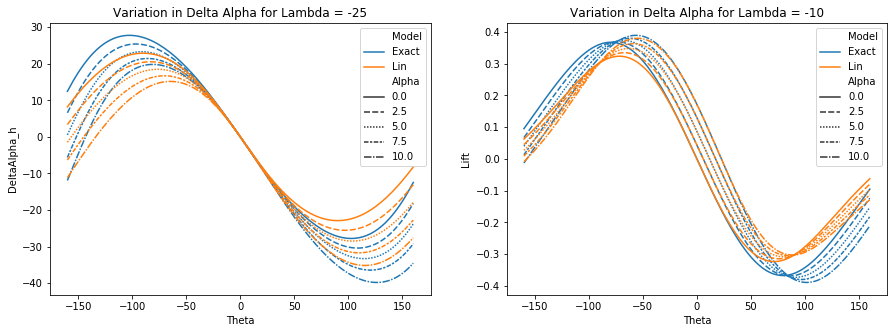

In [170]:
linAlpha = sym.atan(sym.sin(theta)*sym.sin(Lambda)) + sym.cos(theta)*alpha
V = sym.ones(3,1)
sweep = (sym.cos(theta)-1)*Lambda
V[0] = sym.cos(linAlpha)*u*sym.cos(sweep)
V[1] = u*sym.sin(alpha)*1e-19
V[2] = sym.sin(linAlpha)*u*sym.cos(sweep)
linModel = sym.lambdify((alpha,beta,Lambda,theta,u),V)

LinModelData = GetFwtAoAFromModel(TestConditions,linModel,'Lin')
#LinModelData['DeltaAlpha_h'] = LinModelData['Alpha_h']

Data = ModelData.append(LinModelData,sort=False)


# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(1,2,figsize=(15,5))
dat = Data[Data['Lambda']==-25]
sns.lineplot(data = dat,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0],hue='Model')
axes[0].set(title='Variation in Delta Alpha for Lambda = -25')
# axes[0].set(ylim=(-10,10),xlim=(-50,50))

sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[1],hue='Model')
axes[1].set(title='Variation in Delta Alpha for Lambda = -10')
sweep
dat[dat['Theta']==-90]

Thats better than a poke in the eye with a sharp stick!



How does the model used in the paper compare?

[Text(0.5, 1.0, 'Variation in Delta Alpha for Lambda = -10')]

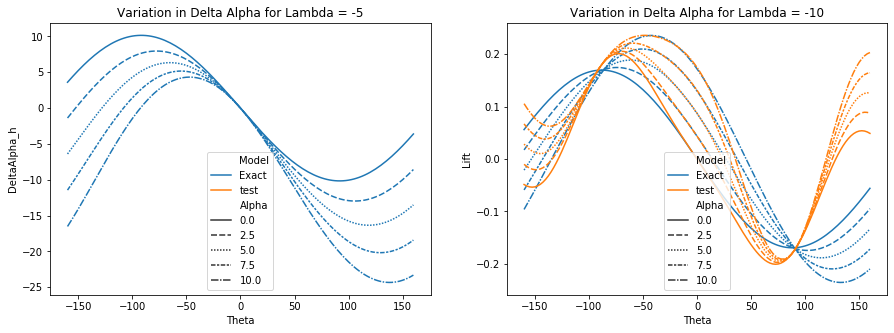

In [172]:
Data = TestConditions.copy()
L = np.deg2rad(Data['Lambda'])
t= np.deg2rad(Data['Theta'])
a = np.deg2rad(Data['Alpha'])
Data['L'] = np.arctan(np.sin(L)*np.sin(t))*np.cos(t)
Data['S'] = L*np.sin(t)**3 + a*np.cos(t)**2
Data['Lift'] = Data['L'] + Data['S']
Data['Model'] = 'test'
Data = ModelData.append(Data,sort=False)


# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(1,2,figsize=(15,5))
dat = Data[Data['Lambda']==-10]
sns.lineplot(data = dat,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0],hue='Model')
axes[0].set(title='Variation in Delta Alpha for Lambda = -5')
# axes[0].set(ylim=(-10,10),xlim=(-50,50))

sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[1],hue='Model')
axes[1].set(title='Variation in Delta Alpha for Lambda = -10')

#axes[1].set(xlim=(-50,50))



my point......

In [176]:
Vh.sub({theta:0})

AttributeError: ImmutableDenseMatrix has no attribute sub.